In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
import time
from datetime import datetime, timedelta
import psycopg2

def plot_output_curve(data: dict, agents: list):
    # Determine the number of agents to set the number of subplots
    num_agents = len(agents)
    fig, axs = plt.subplots(1, num_agents, figsize=(num_agents*5, 4)) # Adjust size as needed
    
    # If there is only one agent, axs will not be an array, so we wrap it in a list
    if num_agents == 1:
        axs = [axs]
    
    for i, agent in enumerate(agents):
        agent_counter = data[agent]
        axs[i].plot(list(agent_counter['arrival_counter'].keys()), list(agent_counter['arrival_counter'].values()), label=f'{agent} arrival', linestyle='--', alpha=0.7)
        axs[i].plot(list(agent_counter['departure_counter'].keys()), list(agent_counter['departure_counter'].values()), label=f'{agent} departure', linestyle='--', alpha=0.7)
        
        axs[i].set_title(f'{agent} Output Curve')
        axs[i].set_xlabel('Time (hr)')
        axs[i].set_xlabel('Cumulative Count')
        axs[i].legend()
        axs[i].grid()
        axs[i].xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout() # Adjust layout to not overlap
    plt.show()

def plot_queue_lengths(data: dict, agents: list):
    ax = plt.figure(figsize=(14, 6)).gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    for agent in agents:
        if agent == 'passenger_service_queue':
            continue
        agent_queue = data[agent]
        ax.plot(list(agent_queue.keys()), list(agent_queue.values()), label=f'{agent}', linestyle='--', alpha=0.7)
        # plt.scatter(list(agent_queue.keys()), list(agent_queue.values()), label=f'{agent}', marker='o', alpha=0.5, s=5)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_title('Queue Lengths')
    ax.set_xlabel('Time (hr)')
    ax.set_xlabel('Queue Length')
    ax.legend()

    ax.grid()
    plt.show()

def plot_rejected_aircraft_counter(data: dict):
    fig, ax = plt.subplots()
    ax.plot(list(data.keys()), list(data.values()), label='Rejected Aircraft')
    # plt.title('Cumulative Number of Rejected Aircraft')
    plt.xlabel('Time (hr)')
    plt.ylabel('Cumulative Number of Rejected Aircraft')
    plt.legend()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.grid()
    plt.show()

def save_simulation_results_sqlite(db_name, parameters, simulation):
    save_metrics_to_sqlite(db_name,
                           parameters['num_park'], 
                           parameters['aircraft_arrival_rate'], 
                           parameters['passenger_arrival_rate'], 
                           parameters['charge_time'], 
                           parameters['terminal_buffer_capacity'],
                           parameters['blocking'],
                           parameters['seed'],
                           simulation)
    
import psycopg2

def save_simulation_results_postgres(db_name, parameters, simulation):
    # PostgreSQL connection string
    user, password, host, port = 'emin', 'emin', 'localhost', '5432'
    conn_str = f"dbname='{db_name}' user='{user}' password='{password}' host='{host}' port='{port}'"
    
    try:
        # Connect to your postgres DB
        conn = psycopg2.connect(conn_str)
        cur = conn.cursor()
        
        # Create table if it doesn't exist (adjust the data types as necessary)
        cur.execute('''
            CREATE TABLE IF NOT EXISTS simulation_metrics (
                id SERIAL PRIMARY KEY, 
                seed INTEGER, 
                num_park INTEGER, 
                aircraft_arrival_rate INTEGER, 
                passenger_arrival_rate INTEGER, 
                charge_time INTEGER, 
                terminal_buffer_capacity REAL, 
                blocking BOOLEAN, 
                aircraft_throughput_rate REAL, 
                terminal_queue_length REAL, 
                avg_num_aircraft_at_surface REAL, 
                passenger_queue_length REAL, 
                variance_in_terminal_queue_length REAL, 
                variance_in_pax_queue_length REAL
            )
        ''')

        # Insert a row
        cur.execute('''
            INSERT INTO simulation_metrics (
                seed, num_park, aircraft_arrival_rate, passenger_arrival_rate, charge_time, terminal_buffer_capacity, blocking, aircraft_throughput_rate, terminal_queue_length, avg_num_aircraft_at_surface, passenger_queue_length, variance_in_terminal_queue_length, variance_in_pax_queue_length
            ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
        ''', (
            parameters['seed'], parameters['num_park'], parameters['aircraft_arrival_rate'], 
            parameters['passenger_arrival_rate'], parameters['charge_time'], parameters['terminal_buffer_capacity'], 
            parameters['blocking'], simulation['aircraft_throughput_rate'], simulation['terminal_queue_length'], 
            simulation['avg_num_aircraft_at_surface'], simulation['passenger_queue_length'], 
            simulation['variance_in_terminal_queue_length'], simulation['variance_in_pax_queue_length']
        ))

        # Commit the transaction
        conn.commit()
        
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if conn:
            # Close the connection
            conn.close()


def save_metrics_to_sqlite(db_name, num_park, aircraft_arrival_rate, passenger_arrival_rate, charge_time, terminal_buffer_capacity, blocking, seed, sim):
    import sqlite3
    conn = sqlite3.connect(f'{db_name}.db')
    c = conn.cursor()
    c.execute('CREATE TABLE IF NOT EXISTS metrics (id INTEGER PRIMARY KEY, seed INTEGER, num_park INTEGER, aircraft_arrival_rate INTEGER, passenger_arrival_rate INTEGER, charge_time INTEGER, terminal_buffer_capacity REAL, blocking INTEGER, aircraft_throughput_rate REAL, terminal_queue_length REAL, avg_num_aircraft_at_surface REAL, passenger_queue_length REAL, variance_in_terminal_queue_length REAL, variance_in_pax_queue_length REAL)')
    c.execute('INSERT INTO metrics (seed, num_park, aircraft_arrival_rate, passenger_arrival_rate, charge_time, terminal_buffer_capacity, blocking, aircraft_throughput_rate, terminal_queue_length, avg_num_aircraft_at_surface, passenger_queue_length, variance_in_terminal_queue_length, variance_in_pax_queue_length) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?,?,?,?)', 
              (seed, num_park, aircraft_arrival_rate, passenger_arrival_rate, charge_time, terminal_buffer_capacity, blocking, round(sim.average_aircraft_throughput(),2), round(sim.average_terminal_queue_length(),2), round(sim.average_num_aircraft_at_surface(),2), round(sim.average_passenger_queue_length(),2), round(sim.variance_in_terminal_queue_length(),2), round(sim.variance_in_pax_queue_length(),2)))
    conn.commit()
    conn.close()

def save_metrics_to_postgres(db_name, num_park, aircraft_arrival_rate, passenger_arrival_rate, charge_time, terminal_buffer_capacity, blocking, seed, sim):
    # PostgreSQL connection string
    user, password, host, port = 'emin', 'emin', 'localhost', '5432'
    conn_str = f"dbname='{db_name}' user='{user}' password='{password}' host='{host}' port='{port}'"
    try:
        # Connect to your postgres DB
        conn = psycopg2.connect(conn_str)
        cur = conn.cursor()
        
        # Create table if it doesn't exist
        cur.execute('CREATE TABLE IF NOT EXISTS metrics (id SERIAL PRIMARY KEY, seed INTEGER, num_park INTEGER, aircraft_arrival_rate INTEGER, passenger_arrival_rate INTEGER, charge_time INTEGER, terminal_buffer_capacity REAL, blocking INTEGER, aircraft_throughput_rate REAL, terminal_queue_length REAL, avg_num_aircraft_at_surface REAL, passenger_queue_length REAL, variance_in_terminal_queue_length REAL, variance_in_pax_queue_length REAL)')
        
        # Insert a row
        cur.execute('INSERT INTO metrics (seed, num_park, aircraft_arrival_rate, passenger_arrival_rate, charge_time, terminal_buffer_capacity, blocking, aircraft_throughput_rate, terminal_queue_length, avg_num_aircraft_at_surface, passenger_queue_length, variance_in_terminal_queue_length, variance_in_pax_queue_length) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)', 
                    (seed, num_park, aircraft_arrival_rate, passenger_arrival_rate, charge_time, terminal_buffer_capacity, blocking, round(sim.average_aircraft_throughput(),2), round(sim.average_terminal_queue_length(),2), round(sim.average_num_aircraft_at_surface(),2), round(sim.average_passenger_queue_length(),2), round(sim.variance_in_terminal_queue_length(),2), round(sim.variance_in_pax_queue_length(),2)))
        
        # Commit the transaction
        conn.commit()
        
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if conn:
            # Close the connection
            conn.close()


# Vertiport surface blocking propogated to the TLOF. Terminal airspace has a finite or infinite buffer

In [2]:
import simpy
import random
import numpy as np
from collections import defaultdict
from typing import List, Dict, Any, Tuple, Union
# Logging
import logging

import logging
from datetime import datetime, timedelta

class SimTimeFormatter(logging.Formatter):
    def __init__(self, sim_env, start_datetime, fmt='%(sim_time)s - %(levelname)s - %(message)s'):
        super().__init__(fmt)
        self.sim_env = sim_env
        # Assume start_datetime is a datetime.datetime object representing the start of the simulation
        self.start_datetime = start_datetime

    def format(self, record):
        # Convert simulation time (in hours) to a datetime object
        sim_datetime = self.start_datetime + timedelta(hours=self.sim_env.now)
        # Format the simulation datetime as %Y%m%d_%H%M%S
        record.sim_time = sim_datetime.strftime('%Y-%m-%d %H:%M:%S')
        return super().format(record)

class Logger:
    def __init__(self, env, simulation_start_datetime, is_logging=True):
        self.env = env
        self.start_datetime = simulation_start_datetime
        self.logger = logging.getLogger(__name__)
        if is_logging:
            self.setup_logger()
        else:
            self.logger.addHandler(logging.NullHandler())
            # self.logger.setLevel(logging.NOTSET)
    
    def setup_logger(self):
        self.logger.setLevel(logging.INFO)
        self.logger_path = f"logs/{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.log"
        self.handler = logging.FileHandler(self.logger_path)        
        # Set logger name using the current date time
        # Use the custom formatter with simulation time and start datetime
        self.formatter = SimTimeFormatter(self.env, self.start_datetime)
        self.handler.setFormatter(self.formatter)

        self.logger.addHandler(self.handler)

    def log(self, message):
        self.logger.info(message)

    def debug(self, *args, **kwargs):
        if self.logger is None:
            raise Exception('Logger not initialized. Call create_logger first.')
        return self.logger.debug(*args, **kwargs)
    
    def info(self, *args, **kwargs):
        if self.logger is None:
            raise Exception('Logger not initialized. Call create_logger first.')
        return self.logger.info(*args, **kwargs)
    
    def warning(self, *args, **kwargs):
        if self.logger is None:
            raise Exception('Logger not initialized. Call create_logger first.')
        return self.logger.warning(*args, **kwargs)

    def error(self, *args, **kwargs):
        if self.logger is None:
            raise Exception('Logger not initialized. Call create_logger first.')
        return self.logger.error(*args, **kwargs)
    
    def critical(self, *args, **kwargs):
        if self.logger is None:
            raise Exception('Logger not initialized. Call create_logger first.')
        return self.logger.critical(*args, **kwargs)        

    def close(self):
        self.logger.removeHandler(self.handler)
        self.handler.close()
 
    
# Pre-generate IDs based on expected numbers
def generate_ids(num_agents, prefix):
    return [f"{prefix}_{i}" for i in range(num_agents)]

class VertiportSimulation:
    def __init__(self, 
                 env, 
                 aircraft_ids, 
                 passenger_ids, 
                 aircraft_mean_interarrival_time, 
                 passenger_mean_interarrival_time,
                 num_park,
                 tlof_mean_service_time,
                 charge_mean_service_time,
                 seat_capacity,
                 termination_event,
                 stochastic,
                 terminal_buffer_capacity,
                 tlof_feedback=True,
                 blocking=False,
                 is_logging=False,
                 seed=0):
        self.env = env
        self.aircraft_ids = iter(aircraft_ids)  # Make iterators
        self.passenger_ids = iter(passenger_ids)
        self.aircraft_mean_interarrival_time = aircraft_mean_interarrival_time
        self.passenger_mean_interarrival_time = passenger_mean_interarrival_time
        self.num_park = num_park
        self.tlof_mean_service_time = tlof_mean_service_time
        self.charge_mean_service_time = charge_mean_service_time/self.num_park
        self.seat_capacity = seat_capacity
        self.termination_event = termination_event
        self.stochastic = stochastic
        self.tlof_feedback = tlof_feedback
        self.blocking = blocking
        self.terminal_buffer_capacity = terminal_buffer_capacity
        self.is_logging = is_logging
        self.simulation_start_datetime = datetime(2024, 1, 1)
        self.seed = seed

        # Servers and queues
        self.tlof_server = simpy.PriorityResource(env, capacity=1)
        self.tlof_server2 = simpy.PriorityResource(env, capacity=1)
        self.park_server = simpy.Resource(env, capacity=1)
        self.passenger_queue = []
        self.aircraft_departure_queue = simpy.Store(env)
        # Statistics
        self.waiting_times = defaultdict(lambda: defaultdict(dict))
        self.arrival_departure_times = defaultdict(lambda: defaultdict(dict))
        self.arrival_departure_counter = defaultdict(lambda: defaultdict(dict))
        self.queue_lengths = defaultdict(lambda: defaultdict(dict))
        self.in_service_counts = defaultdict(lambda: defaultdict(dict))
        self.time_logs = defaultdict(lambda: defaultdict(dict))
        self.process_times = defaultdict(lambda: defaultdict(dict))
        self.rejected_aircraft_counter = 0
        self.surface_aircraft_count = defaultdict(dict)
        self.departing_passenger_queue_length = 0
        self.passenger_service_queue_length = 0
        self.terminal_store = simpy.Store(env, capacity=self.terminal_buffer_capacity)
        self.surface_store = simpy.Store(env, capacity=1)
        # Populate the surface store with the number of parking spots
        # for i in range(num_park):
        #     self.surface_store.put('park')
        self.surface_store.put('park')
        
        # If terminal buffer capacity is not infinite, then populate the terminal store with the capacity
        if self.terminal_buffer_capacity != np.inf:
            for _ in range(self.terminal_buffer_capacity):
                self.terminal_store.put('capacity')

        # Initiate arrival_departure_counter to zero
        self.arrival_departure_counter['aircraft']['arrival_counter'][0] = 0
        self.arrival_departure_counter['aircraft']['departure_counter'][0] = 0
        self.arrival_departure_counter['passenger']['arrival_counter'][0] = 0
        self.arrival_departure_counter['passenger']['departure_counter'][0] = 0
        # Initiate queue lengths to zero
        self.queue_lengths['aircraft_arrival_queue'][0] = 0
        self.queue_lengths['aircraft_departure_queue'][0] = 0
        self.queue_lengths['passenger_queue'][0] = 0
        self.queue_lengths['park_queue_length'][0] = 0

        self.surface_aircraft_count[0] = 0
        self.logger = Logger(env, self.simulation_start_datetime, self.is_logging)

        # Seed the random number generator
        random.seed(seed)
        np.random.seed(seed)

    def convert_hr_to_dt(self, hour: float) -> str:
        """
        Converts the hour to a datetime string.
        """
        return (self.simulation_start_datetime + timedelta(hours=hour)).strftime('%Y-%m-%d %H:%M:%S')

    def update_counter(self, agent_type: str, counter: dict, counter_type: str, change: int):
        last_value = self.get_latest_value(agent_type, counter, counter_type)
        time = self.is_time_overlapping(self.env.now, agent_type, counter)
        counter[agent_type][counter_type][time] = last_value + change

    def get_latest_value(self, agent_type: str, counter: dict, counter_type: str):
        return list(counter[agent_type][counter_type].values())[-1]
    
    def get_latest_value_from_dict(self, counter: dict):
        return list(counter.values())[-1]
    
    def get_latest_queue_length(self, counter: dict, counter_type: str):
        if len(counter[counter_type]) == 0:
            return 0
        return list(counter[counter_type].values())[-1]
    
    def update_aircraft_arrival_queue_length(self, update):
        # Save the tlof queue length
        time = self.is_time_overlapping(time=self.env.now, agent_type='queue', tracker=self.queue_lengths)
        # Get the last value of the tlof queue length
        queue_length = self.get_latest_queue_length(counter=self.queue_lengths, counter_type='aircraft_arrival_queue')
        self.queue_lengths['aircraft_arrival_queue'][time] = queue_length + update 

    def update_park_queue_length(self, update):
        # Save the park queue length
        time = self.is_time_overlapping(time=self.env.now, agent_type='queue', tracker=self.queue_lengths)
        # Get the last value of the park queue length
        queue_length = self.get_latest_queue_length(counter=self.queue_lengths, counter_type='park_queue_length')
        self.queue_lengths['park_queue_length'][time] = queue_length + update

    def update_aircraft_departure_queue_length(self, update):
        # Save the tlof queue length
        time = self.is_time_overlapping(time=self.env.now, agent_type='queue', tracker=self.queue_lengths)
        # Get the last value of the tlof queue length
        queue_length = self.get_latest_queue_length(counter=self.queue_lengths, counter_type='aircraft_departure_queue')
        self.queue_lengths['aircraft_departure_queue'][time] = queue_length + update

    def update_passenger_queue_length(self, update):
        # Save the tlof queue length
        time = self.is_time_overlapping(time=self.env.now, agent_type='queue', tracker=self.queue_lengths)
        # Get the last value of the tlof queue length
        queue_length = self.get_latest_queue_length(counter=self.queue_lengths, counter_type='passenger_queue')
        self.queue_lengths['passenger_queue'][time] = queue_length + update

    def update_passenger_service_queue_length(self, update):
        # Save the tlof queue length
        time = self.is_time_overlapping(time=self.env.now, agent_type='queue', tracker=self.queue_lengths)
        # Get the last value of the tlof queue length
        queue_length = self.get_latest_queue_length(counter=self.queue_lengths, counter_type='passenger_service_queue')
        self.queue_lengths['passenger_service_queue'][time] = queue_length + update

    def aircraft_arrival_process(self):
        while True:
            if self.stochastic:
                yield self.env.timeout(np.random.exponential(self.aircraft_mean_interarrival_time))
            else:
                yield self.env.timeout(self.aircraft_mean_interarrival_time)
            try:
                aircraft_id = next(self.aircraft_ids)
                time = self.is_time_overlapping(self.env.now, 'aircraft', self.arrival_departure_times)
                self.arrival_departure_times['aircraft'][aircraft_id]['arrival_time'] = time
                
                self.logger.debug(f"{aircraft_id} will request terminal buffer at {self.convert_hr_to_dt(self.env.now)}. Num aircraft at terminal buffer: {self.terminal_buffer_capacity - len(self.terminal_store.items)}")
                if self.terminal_buffer_capacity != np.inf and len(self.terminal_store.items) == 0:
                    self.logger.debug(f"{aircraft_id} rejected at {self.convert_hr_to_dt(self.env.now)}")
                    # last_value = self.get_latest_value_from_dict(self.rejected_aircraft_counter)
                    self.rejected_aircraft_counter += 1
                    continue
                else:
                    # Increase the arrival counter
                    self.update_counter('aircraft', self.arrival_departure_counter, 'arrival_counter', 1)
            
                    self.env.process(self.terminal_arrival_process(aircraft_id))
            except StopIteration:
                break  # No more pre-generated aircraft IDs 

        self.termination_event.succeed()     

    def terminal_arrival_process(self, aircraft_id):
        # Request a space from the terminal airspace
        # yield self.env.timeout(0)
        if self.terminal_buffer_capacity == np.inf:
            self.terminal_store.put('capacity')
        
        yield self.env.process(self.request_terminal_buffer(aircraft_id))

        start_time = self.env.now

        if self.blocking:
            yield self.env.process(self.request_surface(aircraft_id))
            
        self.env.process(self.turnaround_process(aircraft_id, start_time))

    def request_terminal_buffer(self, aircraft_id):
        yield self.terminal_store.get()
        # Save the terminal queue length
        self.update_aircraft_arrival_queue_length(update=1)
        self.logger.debug(f"{aircraft_id} entered the terminal buffer at {self.convert_hr_to_dt(self.env.now)}. Num aircraft at terminal buffer: {self.terminal_buffer_capacity - len(self.terminal_store.items)}")
        self.logger.debug(f"Number of aircraft at the terminal buffer from queue length counter: {list(self.queue_lengths['aircraft_arrival_queue'].values())[-1]}")

    def request_surface(self, aircraft_id):
        yield self.surface_store.get()
        self.logger.debug(f"{aircraft_id} got the surface reservation at {self.convert_hr_to_dt(self.env.now)}. Num aircraft at surface: {self.num_park - len(self.surface_store.items)}")

    def turnaround_process(self, aircraft_id, start_time):
        # TLOF and Park handling with exponential service times
        with self.tlof_server.request(priority=0) as request:
            yield request
            # Update the arrival queue length
            self.update_aircraft_arrival_queue_length(update=-1)            
            # Open space in the terminal buffer
            self.terminal_store.put('capacity')
            self.logger.debug(f"{aircraft_id} left the terminal buffer at {self.convert_hr_to_dt(self.env.now)}. Num aircraft at terminal buffer: {self.terminal_buffer_capacity - len(self.terminal_store.items)}")
            self.logger.debug(f"Number of aircraft at the terminal buffer from queue length counter: {list(self.queue_lengths['aircraft_arrival_queue'].values())[-1]}")
            # Save the tlof queue waiting time
            self.waiting_times['aircraft'][aircraft_id]['tlof_arrival_queue_waiting_time'] = self.env.now - start_time
            # Get the landing process time
            if self.stochastic:
                landing_process_time = np.random.exponential(self.tlof_mean_service_time)
            else:
                landing_process_time = self.tlof_mean_service_time
            # Save the landing process time
            yield self.env.timeout(landing_process_time)
        # Save the landing process time
        self.process_times['aircraft'][aircraft_id]['landing_process_time'] = landing_process_time

        # Increase the surface count
        last_value = self.get_latest_value_from_dict(self.surface_aircraft_count)
        self.surface_aircraft_count[self.env.now] = last_value + 1
        # Log the surface count
        self.logger.debug(f"{aircraft_id} landed at {self.convert_hr_to_dt(self.env.now)}. Num aircraft at surface: {self.num_park - len(self.surface_store.items)}")
        
        start_time = self.env.now
        # Save the park queue length
        self.update_park_queue_length(update=1)

        with self.park_server.request() as request:
            yield request
            # Log parking time
            self.logger.debug(f"{aircraft_id} parked at {self.convert_hr_to_dt(self.env.now)}. Num aircraft at surface: {self.num_park - len(self.surface_store.items)}")
            # Update the park queue length
            self.update_park_queue_length(update=-1)
            self.waiting_times['aircraft'][aircraft_id]['park_queue_waiting_time'] = self.env.now - start_time
            if self.stochastic:
                charge_process_time = np.random.exponential(self.charge_mean_service_time)
            else:
                charge_process_time = self.charge_mean_service_time
            yield self.env.timeout(charge_process_time)
            # Save the charge time
            self.process_times['aircraft'][aircraft_id]['charge_process_time'] = charge_process_time
        # Put aircraft in the the available departure queue
        self.aircraft_departure_queue.put(aircraft_id)
        self.time_logs['aircraft'][aircraft_id]['departure_queue_enter_time'] = self.env.now

        self.logger.debug(f"{aircraft_id} charged and entered the departure queue at {self.convert_hr_to_dt(self.env.now)}. Num aircraft at surface: {self.num_park - len(self.surface_store.items)}")
        self.logger.debug(f"Number of aircraft at the departure queue: {list(self.queue_lengths['aircraft_departure_queue'].values())[-1]}")

    def passenger_process(self):
        while True:
            if self.stochastic:
                yield self.env.timeout(np.random.exponential(self.passenger_mean_interarrival_time))
            else:
                yield self.env.timeout(self.passenger_mean_interarrival_time)
            try:
                passenger_id = next(self.passenger_ids)
                time = self.is_time_overlapping(self.env.now, 'passenger', self.arrival_departure_times)
                self.arrival_departure_times['passenger'][passenger_id]['arrival_time'] = self.env.now
                # Increase the arrival counter
                self.update_counter(agent_type='passenger', counter=self.arrival_departure_counter, counter_type='arrival_counter', change=1)
                self.passenger_service_queue_length += 1

                # self.update_passenger_service_queue_length(update=1)
                # Save the tlof queue length
                time = self.is_time_overlapping(time=self.env.now, agent_type='queue', tracker=self.queue_lengths)
                # Get the last value of the tlof queue length
                self.queue_lengths['passenger_service_queue'][time] = self.passenger_service_queue_length   

                # Log the passenger arrival
                self.logger.debug(f"{passenger_id} arrived at {self.convert_hr_to_dt(self.env.now)}. Num passengers at passenger service queue: {list(self.queue_lengths['passenger_service_queue'].values())[-1]}")
                self.logger.debug(f"Number of passengers at the passenger service queue counter: {self.passenger_service_queue_length}")
                    
                self.passenger_queue.append(passenger_id)
                # Save the passenger queue length
                # time = self.is_time_overlapping(self.env.now, 'passenger', self.queue_lengths)
                # self.queue_lengths['passenger_queue'][time] = len(self.passenger_queue)

                if len(self.passenger_queue) >= self.seat_capacity:

                    time = self.is_time_overlapping(self.env.now, 'queue', self.queue_lengths)
                    self.queue_lengths['passenger_service_queue'][time] = self.passenger_service_queue_length             
                    self.env.process(self.pool_passengers())

            except StopIteration:
                break  # No more pre-generated passenger IDs

    def get_aircraft_from_departure_queue(self):
        aircraft_id = yield self.aircraft_departure_queue.get()
        return aircraft_id
        
    def pool_passengers(self):
        departing_passengers = [self.passenger_queue.pop(0) for _ in range(self.seat_capacity)]
        # Get available aircraft from the departure queue
        aircraft_id = yield self.aircraft_departure_queue.get()
        # aircraft_id = self.env.process(self.get_aircraft_from_departure_queue())

        self.time_logs['aircraft'][aircraft_id]['departure_queue_exit_time'] = self.env.now
        # Update the departure queue length
        self.update_aircraft_departure_queue_length(update=1)
        # Log the passenger departure and aircraft departure
        self.logger.debug(f"{departing_passengers} assigned to {aircraft_id} at {self.convert_hr_to_dt(self.env.now)}. Num passengers at passenger service queue: {list(self.queue_lengths['passenger_service_queue'].values())[-1]}")
        self.logger.debug(f"Departure queue length: {list(self.queue_lengths['aircraft_departure_queue'].values())[-1]}")
        # If there are more passengers than the seat capacity, get the first 4 passengers. If there are less than seat_capacity, get all passengers
        # num_pax = len(self.passenger_queue) if len(self.passenger_queue) < self.seat_capacity else self.seat_capacity
        
        self.departing_passenger_queue_length += len(departing_passengers)
        for passenger_id in departing_passengers:
            self.time_logs['passenger'][passenger_id]['departure_queue_exit_time'] = self.env.now
            self.waiting_times['passenger'][passenger_id]['waiting_time'] = self.env.now - self.arrival_departure_times['passenger'][passenger_id]['arrival_time']

        # Blocking of the surface ends here.
        self.surface_store.put('park')
        # Decrese the surface count
        last_value = self.get_latest_value_from_dict(self.surface_aircraft_count)
        self.surface_aircraft_count[self.env.now] = last_value - 1

        # Log surface count
        self.logger.debug(f"Num aircraft at surface: {self.num_park - len(self.surface_store.items)}")
        
        self.env.process(self.departure_process(aircraft_id))


    def departure_process(self, aircraft_id):
        start_time = self.env.now

        if self.tlof_feedback:
            # Request the tlof server
            with self.tlof_server.request(priority=1) as request:
                yield request
                # Save the pushback time
                self.arrival_departure_times['aircraft'][aircraft_id]['pushback_time'] = self.env.now
                # Update the departure queue length
                self.update_aircraft_departure_queue_length(update=-1)            
                # # Update the passenger queue length
                # self.update_passenger_service_queue_length(update=-self.seat_capacity)

                self.passenger_service_queue_length -= self.seat_capacity
                
                time = self.is_time_overlapping(self.env.now, 'queue', self.queue_lengths)
                self.queue_lengths['passenger_service_queue'][time] = self.passenger_service_queue_length            

                # Save the tlof queue waiting time
                self.waiting_times['aircraft'][aircraft_id]['tlof_departure_queue_waiting_time'] = self.env.now - start_time
                if self.stochastic:
                    departure_process_time = np.random.exponential(self.tlof_mean_service_time)
                else:
                    departure_process_time = self.tlof_mean_service_time
                yield self.env.timeout(departure_process_time)
        else:
            with self.tlof_server2.request(priority=1) as request:
                yield request
                # Save the pushback time
                self.arrival_departure_times['aircraft'][aircraft_id]['pushback_time'] = self.env.now
                # Update the departure queue length
                self.update_aircraft_departure_queue_length(update=-1)            
                # # Update the passenger queue length
                self.passenger_service_queue_length -= self.seat_capacity
                
                time = self.is_time_overlapping(self.env.now, 'queue', self.queue_lengths)
                self.queue_lengths['passenger_service_queue'][time] = self.passenger_service_queue_length            

                # Save the tlof queue waiting time
                self.waiting_times['aircraft'][aircraft_id]['tlof_departure_queue_waiting_time'] = self.env.now - start_time
                if self.stochastic:
                    departure_process_time = np.random.exponential(self.tlof_mean_service_time)
                else:
                    departure_process_time = self.tlof_mean_service_time
                yield self.env.timeout(departure_process_time)
        # Save the tlof service time
        self.process_times['aircraft'][aircraft_id]['departure_process_time'] = departure_process_time
        # Update the departure counter
        self.update_counter('aircraft', self.arrival_departure_counter, 'departure_counter', 1)
        # Save passenger departure count
        self.update_counter(agent_type='passenger', counter=self.arrival_departure_counter, counter_type='departure_counter', change=self.seat_capacity)
        # Save departure time
        self.arrival_departure_times['aircraft'][aircraft_id]['departure_time'] = self.env.now

    def is_time_overlapping(self, time: float, agent_type: str, tracker: Dict) -> int:
        if agent_type == 'aircraft':
            if len(tracker) == 0:
                return time
            if time not in list(tracker[agent_type].keys()):
                return time
            time += 1/60/60/1000  # add 0.01 milisecond
            return self.is_time_overlapping(time=time, agent_type=agent_type, tracker=tracker)
        elif agent_type == 'passenger':
            if len(tracker) == 0:
                return time
            if time not in list(tracker[agent_type].keys()):
                return time
            time += 1/60/60/1000
            return self.is_time_overlapping(time=time, agent_type=agent_type, tracker=tracker)
        elif agent_type == 'queue':
            if len(tracker) == 0:
                return time
            if time not in list(tracker.keys()):
                return time
            time += 1/60/60/1000
            return self.is_time_overlapping(time=time, agent_type=agent_type, tracker=tracker)
        else:
            raise ValueError('agent_type must be either aircraft, passenger or tracker')    
        
    def average_aircraft_throughput(self):
        """
        Computes the average hourly aircraft departure rate.
        """
        return list(self.arrival_departure_counter['aircraft']['departure_counter'].values())[-1] / self.env.now
    
    def average_terminal_queue_length(self):
        """
        Computes the average hourly terminal queue length.
        """
        return self.calculate_time_average(self.queue_lengths['aircraft_arrival_queue'])
    
    def average_num_aircraft_at_surface(self):
        """
        Computes the average number of aircraft at the surface.
        """
        return self.calculate_time_average(self.surface_aircraft_count)
    
    def average_passenger_queue_length(self):
        """
        Computes the average number of passengers in the system.
        """
        return self.calculate_time_average(self.queue_lengths['passenger_service_queue'])
    
    def variance_in_terminal_queue_length(self):
        """
        Computes the variance in terminal queue length.
        """
        return self.calculate_variance(self.queue_lengths['aircraft_arrival_queue'])
    
    def variance_in_num_aircraft_at_surface(self):
        """
        Computes the variance in the number of aircraft at the surface.
        """
        return self.calculate_variance(self.surface_aircraft_count)
    
    def variance_in_pax_queue_length(self):
        """
        Computes the variance in the number of passengers in the system.
        """
        return self.calculate_variance(self.queue_lengths['passenger_service_queue'])

    def get_rejected_num_aircraft(self):
        return self.rejected_aircraft_counter

    def calculate_time_average(self, tracker: Dict) -> float:
        keys = list(tracker.keys())  # Assuming keys are sorted and represent hours

        # Find the index for the key immediately after the first two hours
        start_index = 0
        for i, key in enumerate(keys):
            if key - keys[0] > 5:  # Direct comparison in hours
                start_index = i
                break

        # Ensure there's at least one interval after excluding the first several hours
        if start_index == len(keys) - 1:
            return 0  # Return 0 or suitable value if there's no data to compute average

        # Adjust calculation to start from the key after the first two hours
        total_weighted = 0
        for i in range(start_index, len(keys) - 1):
            duration = keys[i+1] - keys[i]
            queue_length = tracker[keys[i]]
            total_weighted += queue_length * duration

        # Adjust total time calculation to exclude the first two hours
        total_time_adjusted = keys[-1] - keys[start_index]

        # Return the average queue length excluding the first two hours
        return total_weighted / total_time_adjusted if total_time_adjusted != 0 else 0    
    
    def calculate_variance(self, tracker: Dict) -> float:
        # First, ensure the average excludes the first two hours
        time_average = self.calculate_time_average(tracker)
        
        keys = list(tracker.keys())
        
        # Find the start index after the first two hours
        start_index = 0
        for i, key in enumerate(keys):
            if key - keys[0] > 5:  # Using hours directly for comparison
                start_index = i
                break
        
        # Check to ensure there's data to compute after the first two hours
        if start_index == len(keys) - 1:
            return 0  # Return 0 or suitable value if there's no data to compute variance
        
        total_variance = 0
        for i in range(start_index, len(keys) - 1):
            duration = keys[i+1] - keys[i]
            queue_length = tracker[keys[i]]
            total_variance += (queue_length - time_average)**2 * duration
        
        # Adjust total time calculation to exclude the first two hours
        total_time_adjusted = keys[-1] - keys[start_index]
        
        return total_variance / total_time_adjusted if total_time_adjusted != 0 else 0


In [3]:
def run_simulation(aircraft_arrival_rate, 
                   passenger_arrival_rate, 
                   charge_time, 
                   num_park, 
                   num_aircraft, 
                   num_passenger, 
                   seat_capacity, 
                   tlof_feedback,
                   tlof_time, 
                   stochastic, 
                   blocking, 
                   terminal_buffer_capacity,
                   seed,
                   is_logging=False):
    parameters = {
        'aircraft_arrival_rate': aircraft_arrival_rate,
        'passenger_arrival_rate': passenger_arrival_rate,
        'charge_time': charge_time,
        'num_park': num_park,
        'num_aircraft': num_aircraft,
        'num_passenger': num_passenger,
        'seat_capacity': seat_capacity,
        'tlof_feedback': tlof_feedback,
        'tlof_time': tlof_time,
        'tlof_feedback': tlof_feedback,
        'stochastic': stochastic,
        'blocking': blocking,
        'terminal_buffer_capacity': terminal_buffer_capacity,
        'seed': seed
    }
    env = simpy.Environment()
    aircraft_mean_interarrival_time = 1/aircraft_arrival_rate # inter-arrival time in hours
    passenger_mean_interarrival_time = 1/passenger_arrival_rate # inter-arrival time in hours
    tlof_mean_service_time = tlof_time/60 # TLOF service time in hours
    charge_mean_service_time = charge_time/60 # Park service time in hours

    aircraft_ids = generate_ids(num_aircraft, "Aircraft")
    passenger_ids = generate_ids(num_passenger, "Passenger")
    termination_event = env.event()
    simulation = VertiportSimulation(env, 
                                     aircraft_ids, 
                                     passenger_ids, 
                                     num_park=num_park,
                                     aircraft_mean_interarrival_time=aircraft_mean_interarrival_time, 
                                     passenger_mean_interarrival_time=passenger_mean_interarrival_time, 
                                     tlof_mean_service_time=tlof_mean_service_time, 
                                     charge_mean_service_time=charge_mean_service_time,
                                     seat_capacity=seat_capacity,
                                     termination_event=termination_event,
                                     tlof_feedback=tlof_feedback,
                                     stochastic=stochastic,
                                     blocking=blocking,
                                     terminal_buffer_capacity=terminal_buffer_capacity,
                                     is_logging=is_logging,
                                     seed=seed)
    env.process(simulation.passenger_process())
    env.process(simulation.aircraft_arrival_process())
    env.run(until=termination_event)
    return parameters, simulation

    
def print_metrics(simulation):
    print(f"Average hourly aircraft departure rate: {round(simulation.average_aircraft_throughput(),2)}")
    print(f"Average hourly terminal queue length: {round(simulation.average_terminal_queue_length(),2)}")
    print(f"Average number of aircraft at the surface: {round(simulation.average_num_aircraft_at_surface(),2)}")
    print(f"Average number passenger queue length: {round(simulation.average_passenger_queue_length(),2)}")

def visualize_results(simulation):    
    plot_queue_lengths(data=simulation.queue_lengths, agents=['aircraft_arrival_queue', 'aircraft_departure_queue', 'passenger_service_queue', 'park_queue_length'])
    plot_output_curve(data=simulation.arrival_departure_counter, agents=['aircraft', 'passenger'])
    # plot_rejected_aircraft_counter(simulation.rejected_aircraft_counter)

Average hourly aircraft departure rate: 16.31
Average hourly terminal queue length: 27.86
Average number of aircraft at the surface: 0.46
Average number passenger queue length: 7428.74


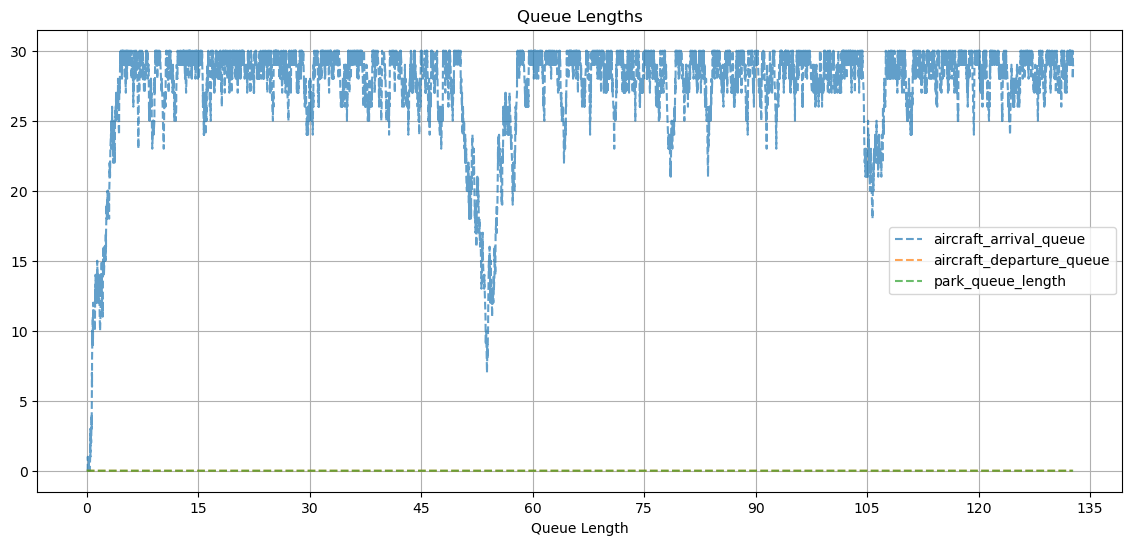

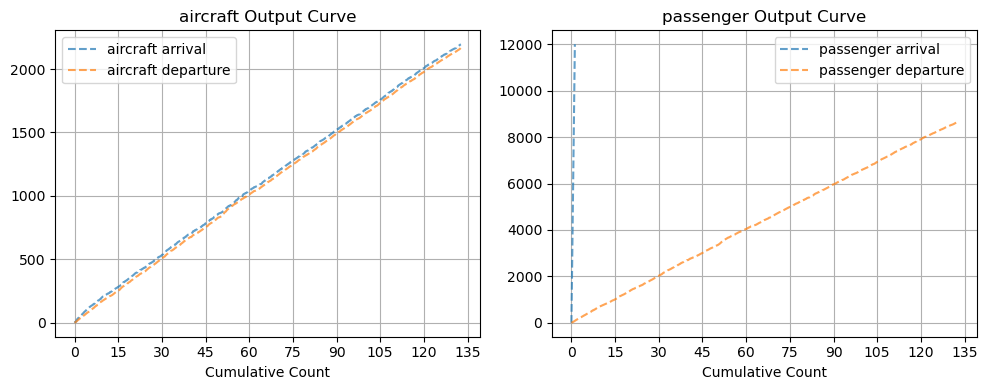

In [4]:
aircraft_arrival_rate = 23 # aircraft per hour
passenger_arrival_rate = 10000 # passengers per hour
charge_time = 10 # Charge service time in minutes 
num_park = 6
charge_rate = 60/charge_time * num_park
num_aircraft = 3000
num_passenger = num_aircraft*4
seat_capacity = 4 
tlof_time = 1 # TLOF service time in minutes
stochastic = True
blocking = True
terminal_buffer_capacity = 30
parameters, simulation = run_simulation(aircraft_arrival_rate=aircraft_arrival_rate,
                                        passenger_arrival_rate=passenger_arrival_rate,
                                        charge_time=charge_time,
                                        num_park=num_park,
                                        num_aircraft=num_aircraft,
                                        num_passenger=num_passenger,
                                        seat_capacity=seat_capacity,
                                        tlof_time=tlof_time,
                                        tlof_feedback=True,
                                        stochastic=stochastic,
                                        blocking=blocking,
                                        terminal_buffer_capacity=terminal_buffer_capacity,
                                        is_logging=False,
                                        seed=0)

print_metrics(simulation)
visualize_results(simulation)
# save_simulation_results(parameters, simulation)

In [7]:
from sqlalchemy import create_engine
import seaborn as sns

db_name, user, password, host, port = "mm1k", "emin", "emin", "localhost", "5432"

engine = create_engine(f'postgresql://{user}:{password}@{host}:{port}/{db_name}')

import pandas as pd

sql_query = 'SELECT * FROM simulation_metrics' # Replace with your actual SQL query
df = pd.read_sql_query(sql_query, con=engine)
df['total_aircraft_and_pax_queue_length'] = df['terminal_queue_length'] + df['passenger_queue_length']
df['rho_surface'] = df['aircraft_arrival_rate'] / (60/df['charge_time']*df['num_park'])
df['p_blocking'] = df['num_rejected_aircraft'] / 2500
df['eff_arrival_rate'] = df['aircraft_arrival_rate'] * (1-df['p_blocking'])

engine.dispose()

df.head()

,id,tlof_feedback,seed,num_park,aircraft_arrival_rate,passenger_arrival_rate,charge_time,terminal_buffer_capacity,blocking,num_rejected_aircraft,aircraft_throughput_rate,terminal_queue_length,avg_num_aircraft_at_surface,passenger_queue_length,variance_in_terminal_queue_length,variance_in_pax_queue_length,total_aircraft_and_pax_queue_length,rho_surface,p_blocking,eff_arrival_rate
0,1,True,3,5,10,10000,5,10.0,True,0,9.99,0.36,0.17,4882.69,0.69,7849172.5,4883.05,0.166667,0.0,10.0
1,2,True,4,5,10,10000,5,10.0,True,0,10.00,0.33,0.17,4919.70,0.57,8123211.0,4920.03,0.166667,0.0,10.0
2,3,True,11,5,10,10000,5,10.0,True,0,10.09,0.30,0.17,4836.78,0.51,8002084.0,4837.08,0.166667,0.0,10.0
3,4,True,8,5,10,10000,5,10.0,True,0,10.03,0.32,0.17,4928.41,0.56,8058404.0,4928.73,0.166667,0.0,10.0
4,5,True,14,5,10,10000,5,10.0,True,0,10.16,0.32,0.17,4865.02,0.59,7868014.0,4865.34,0.166667,0.0,10.0


/var/folders/r1/5g3krykx00z1v1j0y0sgryb00000gn/T/ipykernel_29586/1078063691.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['eff_arrival_rate'] = df_filt['aircraft_arrival_rate'] * (1-df_filt['p_blocking'])


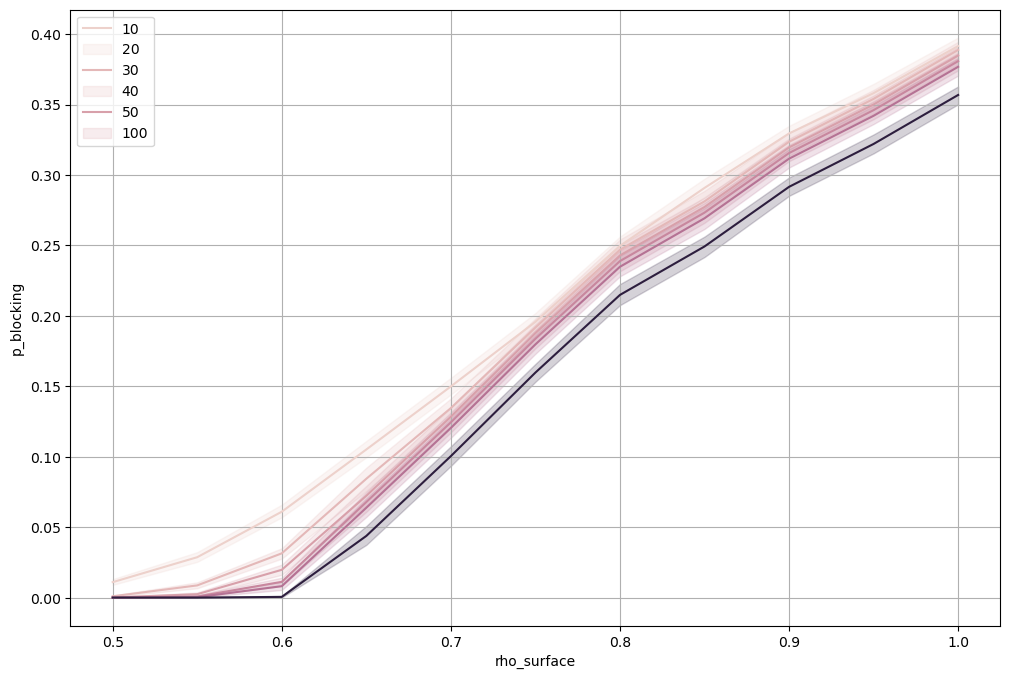

In [8]:
# Plot rho_surface vs terminal queue length for different terminal buffer capacities
plt.figure(figsize=(12, 8))
charge_time = 15
rho_surface = df['num_park'].unique()[0] * (60/charge_time)
df_filt = df[df['charge_time'] == charge_time]
df_filt['eff_arrival_rate'] = df_filt['aircraft_arrival_rate'] * (1-df_filt['p_blocking'])
# df_filt = df_filt[df_filt['eff_arrival_rate'] < rho_surface]
sns.lineplot(data=df_filt, x='rho_surface', y='p_blocking', hue='terminal_buffer_capacity')
plt.legend(['10', '20', '30', '40', '50', '100'])
plt.grid()
# plt.yticks(np.arange(0, 100, 10));

/var/folders/r1/5g3krykx00z1v1j0y0sgryb00000gn/T/ipykernel_29586/3999864116.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['eff_arrival_rate'] = df_filt['aircraft_arrival_rate'] * (1-df_filt['p_blocking'])


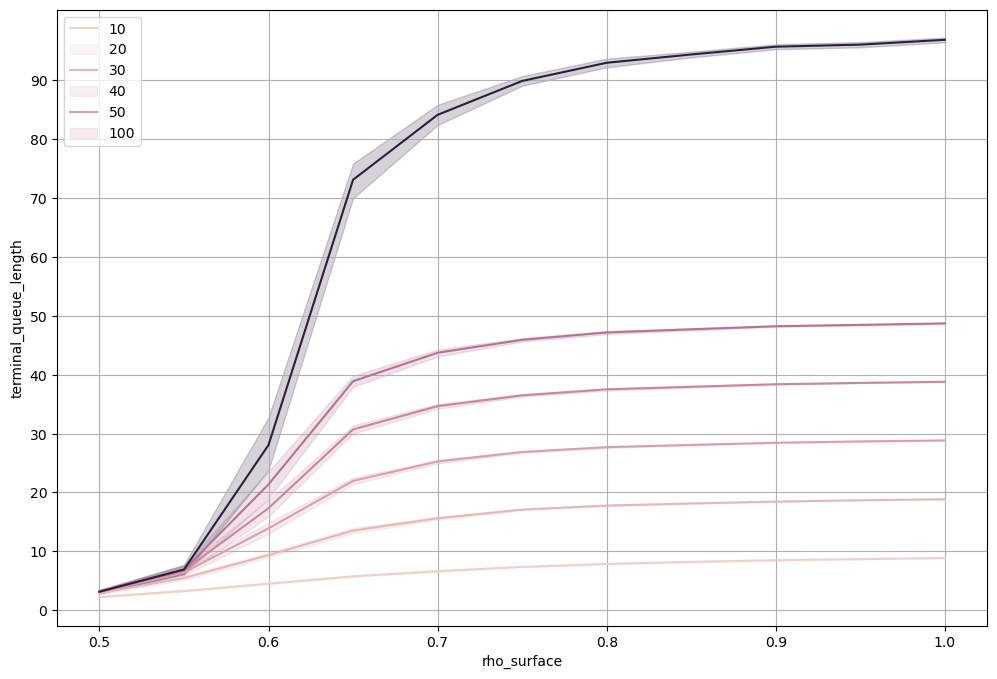

In [9]:
# Plot rho_surface vs terminal queue length for different terminal buffer capacities
plt.figure(figsize=(12, 8))
charge_time = 15
rho_surface = df['num_park'].unique()[0] * (60/charge_time)
df_filt = df[df['charge_time'] == charge_time]
df_filt['eff_arrival_rate'] = df_filt['aircraft_arrival_rate'] * (1-df_filt['p_blocking'])
# Only keep the rows where aircraft_arrival_rate is less than the effective arrival rate
df_filt = df_filt[df_filt['aircraft_arrival_rate'] <= rho_surface]
sns.lineplot(data=df_filt, x='rho_surface', y='terminal_queue_length', hue='terminal_buffer_capacity')
plt.legend(['10', '20', '30', '40', '50', '100'])
plt.grid()
plt.yticks(np.arange(0, 100, 10));

In [1129]:
def mm1k_queue_metrics(lam, mu, K):
    # Calculate the state probabilities Pn
    rho = lam / mu
    if rho > 1:
        return "The system is unstable"
    elif rho != 1:
        L = rho/(1-rho) - (K+1)*rho**(K+1)/(1-rho**(K+1))
        loss_rate = (1-rho)*rho**K/(1-rho**(K+1))
    else:
        L = K/2
        loss_rate = 1/(K+1)

    eff_lambda = lam*(1-loss_rate)
    eff_rho = eff_lambda/mu
    W = L/eff_lambda
    Wq = W - 1/mu
    Lq = L-eff_rho

    return L, Lq, W, Wq, loss_rate, rho, eff_lambda, eff_rho
    
# Generate the arrival rates
_lambda = np.linspace(10, 40, 100)
mu = 40
buffer = [5, 10, 20, 30, 40, 50, 100]

df = pd.DataFrame()

for k in buffer:
    for l in _lambda:
        L, Lq, W, Wq, loss_rate, rho, eff_lambda, eff_rho = mm1k_queue_metrics(l, mu, k)
        df_new = pd.DataFrame({'lam': l, 'L': L, 'Lq': Lq, 'W': W, 'Wq': Wq, 'loss_rate': loss_rate, "rho":rho, 'eff_lambda': eff_lambda, 'eff_rho': eff_rho, 'K': k}, index=[0])
        df = pd.concat([df, df_new])

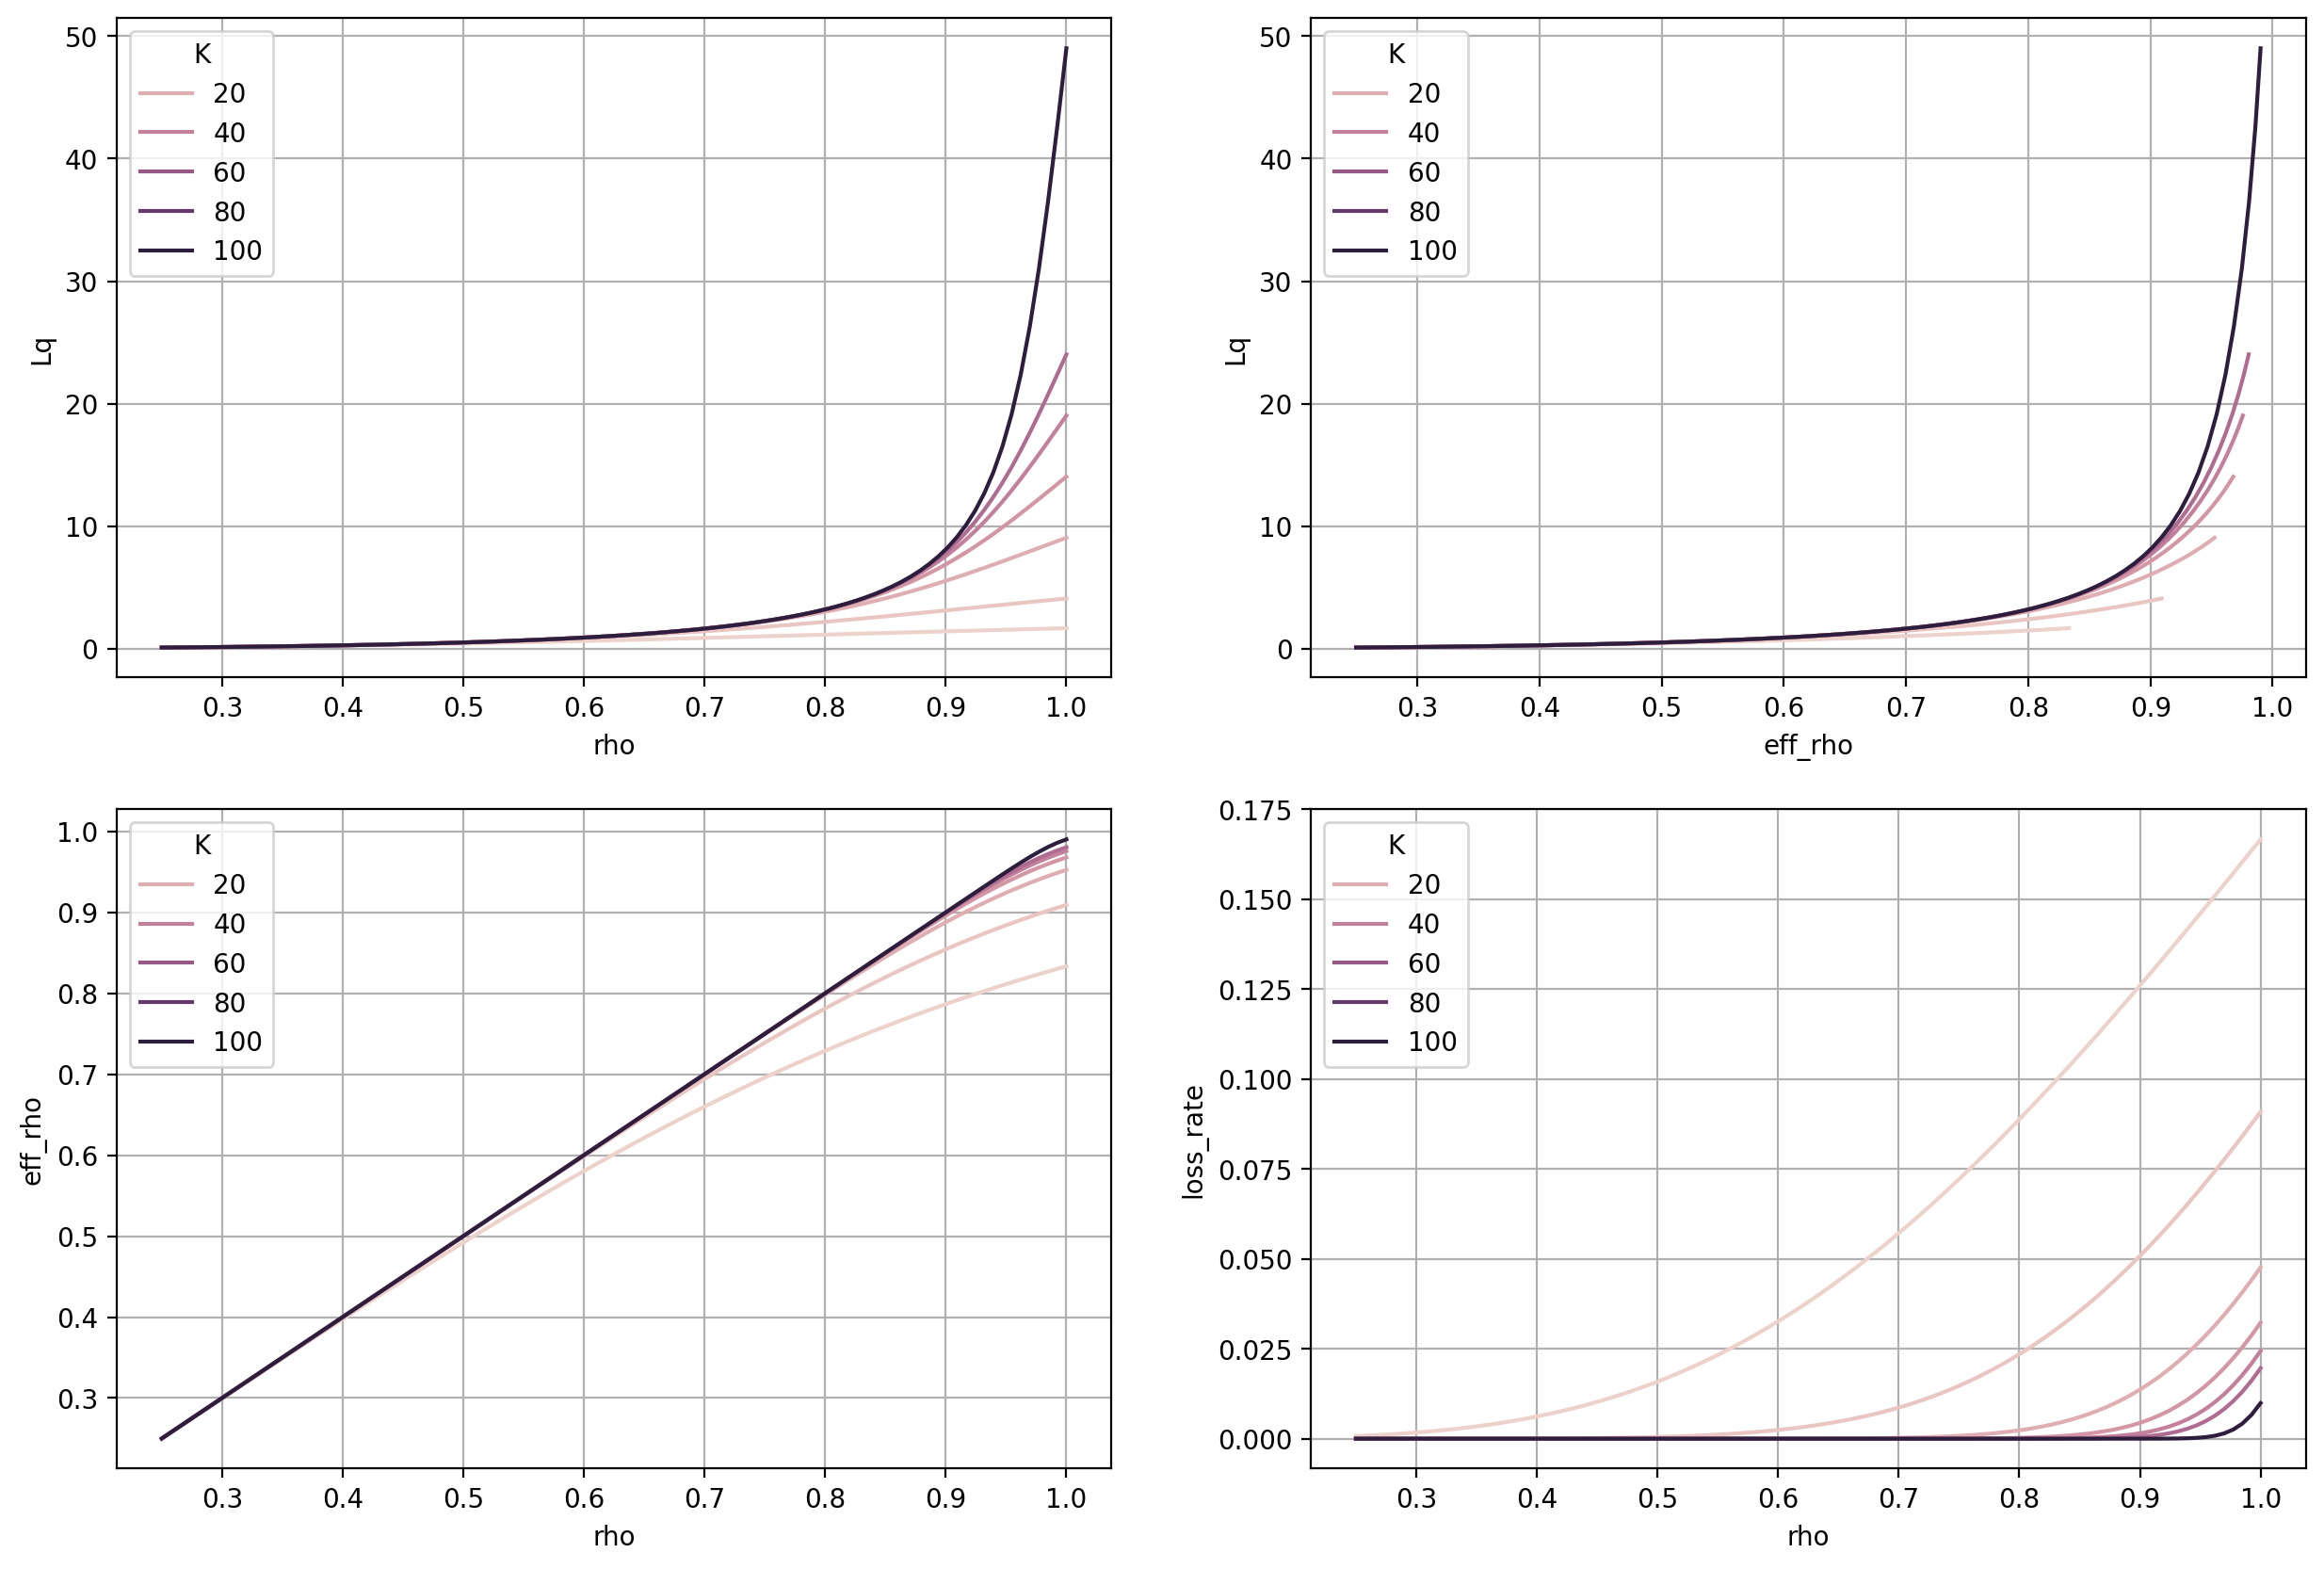

In [1132]:
# Plot the queue metrics
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the queue metrics
fig, ax = plt.subplots(2, 2, figsize=(15, 10), dpi=200)

sns.lineplot(data=df, x="rho", y="Lq", hue="K", ax=ax[0, 0])

sns.lineplot(data=df, x="eff_rho", y="Lq", hue="K", ax=ax[0, 1])

sns.lineplot(data=df, x="rho", y="eff_rho", hue="K", ax=ax[1, 0])

sns.lineplot(data=df, x="rho", y="loss_rate", hue="K", ax=ax[1, 1])

# Set grid
ax[0, 0].grid(True)
ax[0, 1].grid(True)
ax[1, 0].grid(True)
ax[1, 1].grid(True)

In [131]:
import math

def mmck_metrics(lam, mu, c, K):
    # Calculate the basic utilization
    rho = lam / (c * mu)
    
    # Calculate p0
    p0 = (sum((lam / mu) ** n / (1 if n <= c else c ** (n - c) * math.factorial(c)) for n in range(c)) + 
          sum((lam / mu) ** n / (c ** (n - c) * math.factorial(c)) for n in range(c, K + 1))) ** -1
    
    # Calculate loss rate (blocking probability)
    loss_rate = ((lam / mu) ** K / (c ** (K - c) * math.factorial(c))) * p0
    
    # Calculate effective lambda considering the loss rate
    eff_lambda = lam * (1 - loss_rate)
    
    # Calculate L and Lq using the derived probabilities
    L = sum(n * ((lam / mu) ** n / (1 if n <= c else c ** (n - c) * math.factorial(c))) * p0 for n in range(1, K + 1))
    Lq = sum((n - c) * ((lam / mu) ** n / (c ** (n - c) * math.factorial(c))) * p0 for n in range(c + 1, K + 1))
    
    # Calculate W and Wq using Little's Law
    W = L / eff_lambda
    Wq = Lq / eff_lambda
    
    # Calculate effective utilization considering the loss rate
    eff_rho = eff_lambda / (c * mu)
    
    return L, Lq, W, Wq, loss_rate, rho, eff_lambda, eff_rho


# Generate the arrival rates
_lambda = np.linspace(10, 40, 100)
mu = 40/5
buffer = [5, 10, 20, 30, 40, 50, 100]

df = pd.DataFrame()

for k in buffer:
    for l in _lambda:
        L, Lq, W, Wq, loss_rate, rho, eff_lambda, eff_rho = mmck_metrics(l, mu, 5, k)
        df_new = pd.DataFrame({'lam': l, 'L': L, 'Lq': Lq, 'W': W, 'Wq': Wq, 'loss_rate': loss_rate, "rho":rho, 'eff_lambda': eff_lambda, 'eff_rho': eff_rho, 'K': k}, index=[0])
        df = pd.concat([df, df_new])

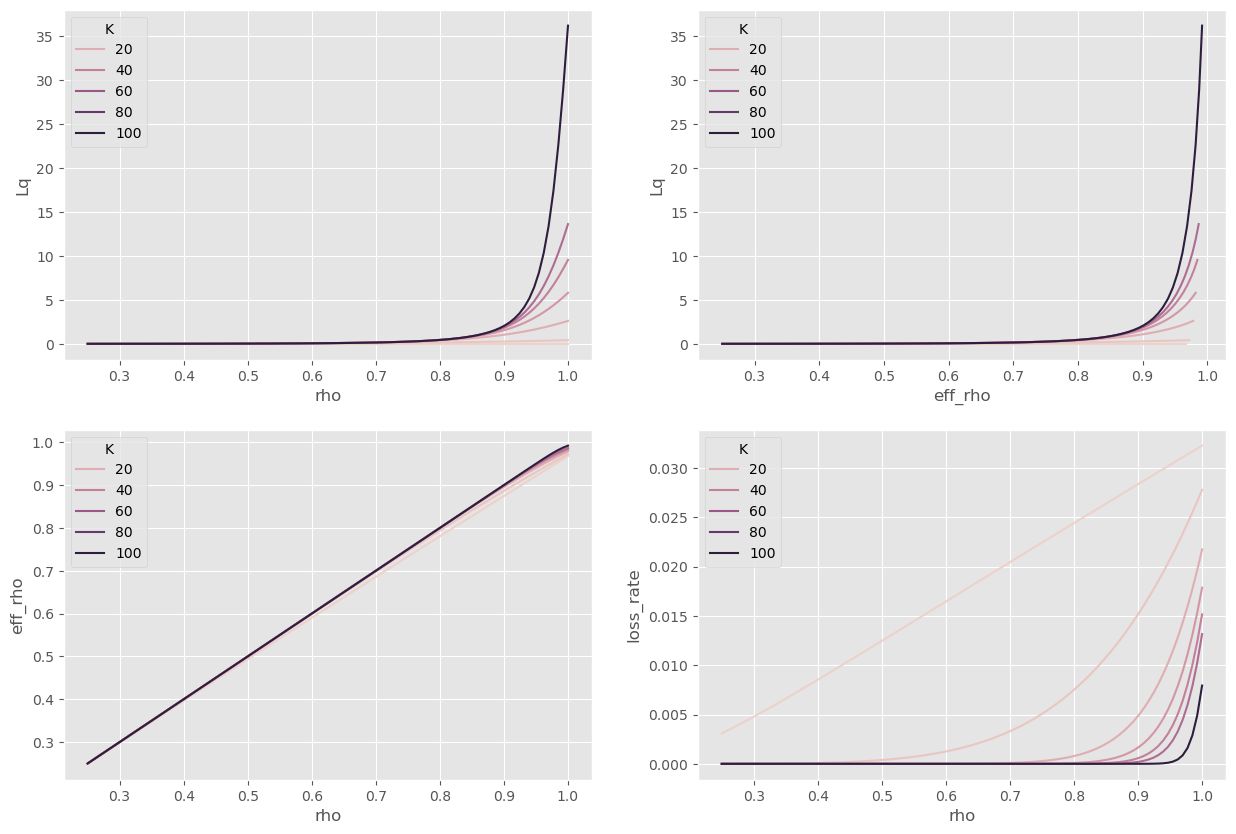

In [132]:
# Plot the queue metrics
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the queue metrics
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

sns.lineplot(data=df, x="rho", y="Lq", hue="K", ax=ax[0, 0])

sns.lineplot(data=df, x="eff_rho", y="Lq", hue="K", ax=ax[0, 1])

sns.lineplot(data=df, x="rho", y="eff_rho", hue="K", ax=ax[1, 0])

sns.lineplot(data=df, x="rho", y="loss_rate", hue="K", ax=ax[1, 1])

# Set grid
ax[0, 0].grid(True)
ax[0, 1].grid(True)
ax[1, 0].grid(True)
ax[1, 1].grid(True)

The system stability condition is not met

The system stability condition is not met

The system stability condition is not met

The system stability condition is not met

The system stability condition is not met

The system stability condition is not met

The system stability condition is not met



<Axes: xlabel='rho', ylabel='loss_rate'>

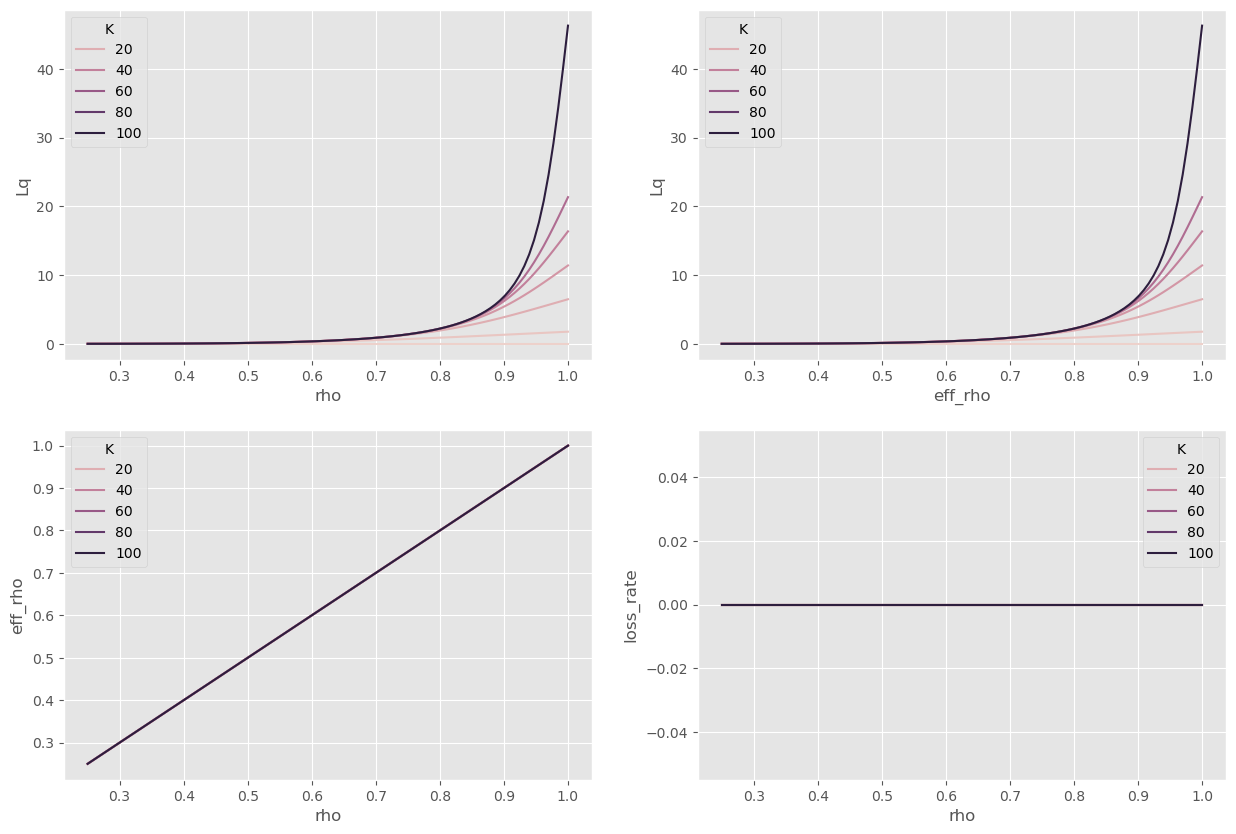

In [134]:
import math

class QueueMMCK:
    def __init__(self, num_servers, arrival_rate, service_rate, capacity):
        err = None
        err_msg = ''
        if num_servers <= 0:
            err = True
            err_msg += 'The number of servers must be strictly greater than 0\n'
        if arrival_rate <= 0:
            err = True
            err_msg += 'The arrival rate must be strictly greater than 0\n'
        if service_rate <= 0:
            err = True
            err_msg += 'The service rate must be strictly greater than 0\n'
        if capacity < num_servers:
            err = True
            err_msg += 'The system capacity must be greater than the number of servers\n'
        if err is True:
            print(err_msg)
            exit(-1)

        self.s = num_servers
        self.arrival_rate = arrival_rate
        self.service_rate = service_rate
        self.capacity = capacity
        self.u = self.arrival_rate / self.service_rate
        self.rho = self.u / self.s
        if self.rho >= 1:
            print('The system stability condition is not met\n')
            exit(-1)
        self.p0 = 1 / (helpers.taylor_exp(self.u, self.s - 1) + (self.u ** self.s / math.factorial(self.s)) * helpers.geometric_series_sum(0, self.capacity - self.s, self.u / self.s))

    # Probability that n clients are in the system Pn
    def pn(self, n):
        if n == 0:
            return self.p0
        elif n > self.capacity:
            return 0
        elif n <= self.s:
            return self.u ** n * self.p0 / math.factorial(n)
        else:
            return self.u ** n * self.p0 / (math.factorial(self.s) * pow(self.s, n - self.s))

    # Entry rate
    def entry_rate(self):
        return self.arrival_rate * (1 - self.pn(self.capacity))

    # Average number of clients in the queue
    def avg_clients_in_queue(self):
        if self.rho == 1:
            return (self.p0 * self.s ** self.s * (self.capacity - self.s) * (self.capacity - self.s + 1)) / (2 * math.factorial(self.s))
        else:
            return (self.p0 * (self.rho * self.s) ** self.s * self.rho * (1 - self.rho ** (self.capacity - self.s + 1) - (1 - self.rho) * (self.capacity - self.s + 1) * self.rho ** (self.capacity - self.s))) / (math.factorial(self.s) * pow((1 - self.rho), 2))

    # Average number of clients in the system
    def avg_clients_in_system(self):
        return self.avg_clients_in_queue() + self.entry_rate() / self.service_rate

    # Average waiting time in the queue
    def avg_waiting_time_in_queue(self):
        return self.avg_clients_in_queue() / self.entry_rate()

    # Average time spent in the system
    def avg_time_in_system(self):
        return self.avg_waiting_time_in_queue() + (1 / self.service_rate)

# Helpers module
class helpers:
    @staticmethod
    def taylor_exp(x, n):
        result = 0
        for i in range(n + 1):
            result += pow(x, i) / math.factorial(i)
        return result

    @staticmethod
    def geometric_series_sum(s, e, q):
        if q == 1:
            return e - s + 1
        else:
            return pow(q, s) * (1 - pow(q, (e - s + 1))) / (1 - q)


# Generate the arrival rates
_lambda = np.linspace(10, 40, 100)
mu = 40/5
buffer = [5, 10, 20, 30, 40, 50, 100]

df = pd.DataFrame()

for k in buffer:
    for l in _lambda:
        mmck = QueueMMCK(5, l, mu, k)
        L = mmck.avg_clients_in_system()
        Lq = mmck.avg_clients_in_queue()
        W = mmck.avg_time_in_system()
        Wq = mmck.avg_waiting_time_in_queue()
        loss_rate = 1 - mmck.entry_rate() / (l * (1 - mmck.pn(k)))
        rho = l / (5 * mu)
        eff_lambda = l * (1 - loss_rate)
        eff_rho = eff_lambda / (5 * mu)
        df_new = pd.DataFrame({'lam': l, 'L': L, 'Lq': Lq, 'W': W, 'Wq': Wq, 'loss_rate': loss_rate, "rho":rho, 'eff_lambda': eff_lambda, 'eff_rho': eff_rho, 'K': k}, index=[0])
        df = pd.concat([df, df_new])

# Plot the queue metrics
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the queue metrics
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

sns.lineplot(data=df, x="rho", y="Lq", hue="K", ax=ax[0, 0])

sns.lineplot(data=df, x="eff_rho", y="Lq", hue="K", ax=ax[0, 1])

sns.lineplot(data=df, x="rho", y="eff_rho", hue="K", ax=ax[1, 0])

sns.lineplot(data=df, x="rho", y="loss_rate", hue="K", ax=ax[1, 1])



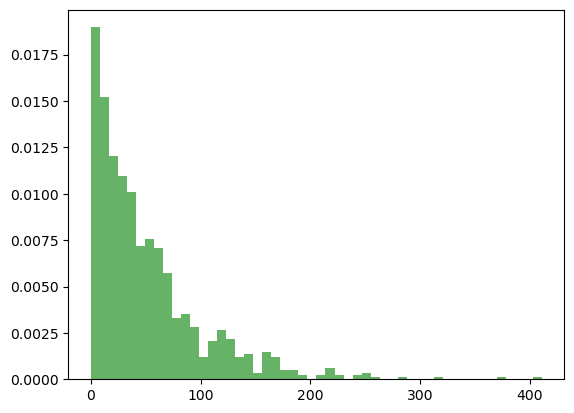

In [72]:
# Create histogram of the exponential distribution
data = np.random.exponential(50, 1000)
plt.hist(data, bins=50, density=True, alpha=0.6, color='g')
plt.show()

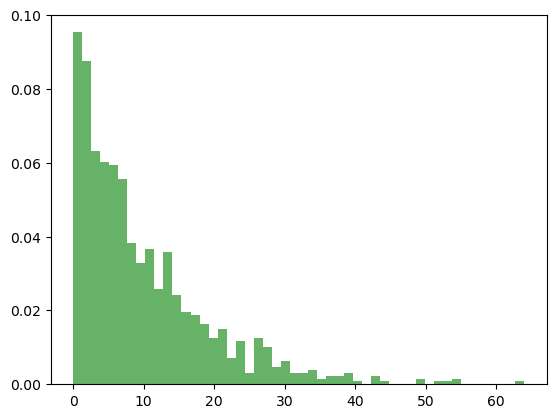

In [73]:
# Create histogram of the exponential distribution
data = np.random.exponential(10, 1000)
plt.hist(data, bins=50, density=True, alpha=0.6, color='g')
plt.show()